In [1]:
import numpy as np
import pandas as pd
import os
from tqdm.notebook import tqdm
import cv2
import matplotlib.pyplot as plt
import pickle
import re

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM, Flatten, Input, Embedding,Concatenate, Dropout, add, concatenate
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences, plot_model, to_categorical

2024-08-02 14:00:10.330757: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-02 14:00:10.330881: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-02 14:00:10.452650: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
BASE_DIR = "/kaggle/input/flickr8kimagescaptions/flickr8k/"
WORKING_DIR = "/kaggle/working"

# VGG16 Model Used For Feature Extraction

In [5]:
vgg16  = VGG16()
vgg_model = Model(inputs=vgg16.inputs,outputs=vgg16.layers[-2].output)
vgg_model.summary()

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
features_dict = {}
img_directory = os.path.join(BASE_DIR,"images")

for image_name in tqdm(os.listdir(img_directory)):
    image_path = img_directory + "/" + image_name
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image = cv2.resize(image,(224,224),cv2.INTER_CUBIC)
    image = image.reshape(1,image.shape[0],image.shape[1],image.shape[2])
    image = preprocess_input(image)
    feature = vgg_model.predict(image, verbose=0)
    image_id = image_name.split(".")[0]
    features_dict[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

I0000 00:00:1722607244.112844      87 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [7]:
with open(os.path.join(WORKING_DIR,'image_features.pkl'), "wb") as file:
    pickle.dump(features_dict,file)

In [8]:
with open(os.path.join(WORKING_DIR,'image_features.pkl'), "rb") as file:
    image_features = pickle.load(file)

In [9]:
len(image_features)

8091

In [10]:
len(list(image_features.values())[0][0])

4096

### Note - There are total 8091 images and each image has feature size of 4096

# Load Caption Text

In [11]:
with open(os.path.join(BASE_DIR,'captions.txt'),"r") as file:
    next(file)
    caption = file.read()

In [12]:
caption_mapping =  {}

for line in tqdm(caption.split("\n")):
    token = line.split(",")
    if len(token)<2:
        continue
    image_id, caption_text = token[0],token[1:]
    image_id = image_id.split(".")[0]
    caption_text = " ".join(caption_text)
    if image_id not in caption_mapping.keys():
        caption_mapping[image_id] = []
    caption_mapping[image_id].append(caption_text)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [13]:
len(caption_mapping)

8091

### Now, for each image the caption in added in list form in caption_mapping dictionary

# Text Preprocessing

In [14]:
def preprocess_text(caption_mapping):
    for image_id,caption in caption_mapping.items():
        for index in range(len(caption)):
            caption_text = caption[index].lower()
            caption_text = re.sub("\W+"," ",caption_text)
            caption_text = "startseq " + " ".join([word for word in caption_text.split() if len(word)>1]) + " endseq"
            caption_text = re.sub("\s+"," ",caption_text)
            caption[index] = caption_text

In [15]:
caption_mapping['1024138940_f1fefbdce1']

['Two different breeds of brown and white dogs play on the beach .',
 'Two dogs are making a turn on a soft sand beach .',
 'Two dogs playing in the sand at the beach .',
 'Two dogs playing together on a beach .',
 'Two large tan dogs play along a sandy beach .']

In [16]:
preprocess_text(caption_mapping)

In [17]:
caption_mapping['1024138940_f1fefbdce1']

['startseq two different breeds of brown and white dogs play on the beach endseq',
 'startseq two dogs are making turn on soft sand beach endseq',
 'startseq two dogs playing in the sand at the beach endseq',
 'startseq two dogs playing together on beach endseq',
 'startseq two large tan dogs play along sandy beach endseq']

In [18]:
all_caption = []
for key in caption_mapping:
    for caption in caption_mapping[key]:
        all_caption.append(caption)

In [19]:
all_caption[:12]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq',
 'startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq',
 'startseq little girl is sitting in front of large painted rainbow endseq']

# Word Tokenize

In [20]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_caption)

In [21]:
vocab_size = len(tokenizer.word_index)+1
print(vocab_size)

8467


In [22]:
max_length = max([len(caption.split(" ")) for caption in all_caption])
print(max_length)

35


# Model Creation

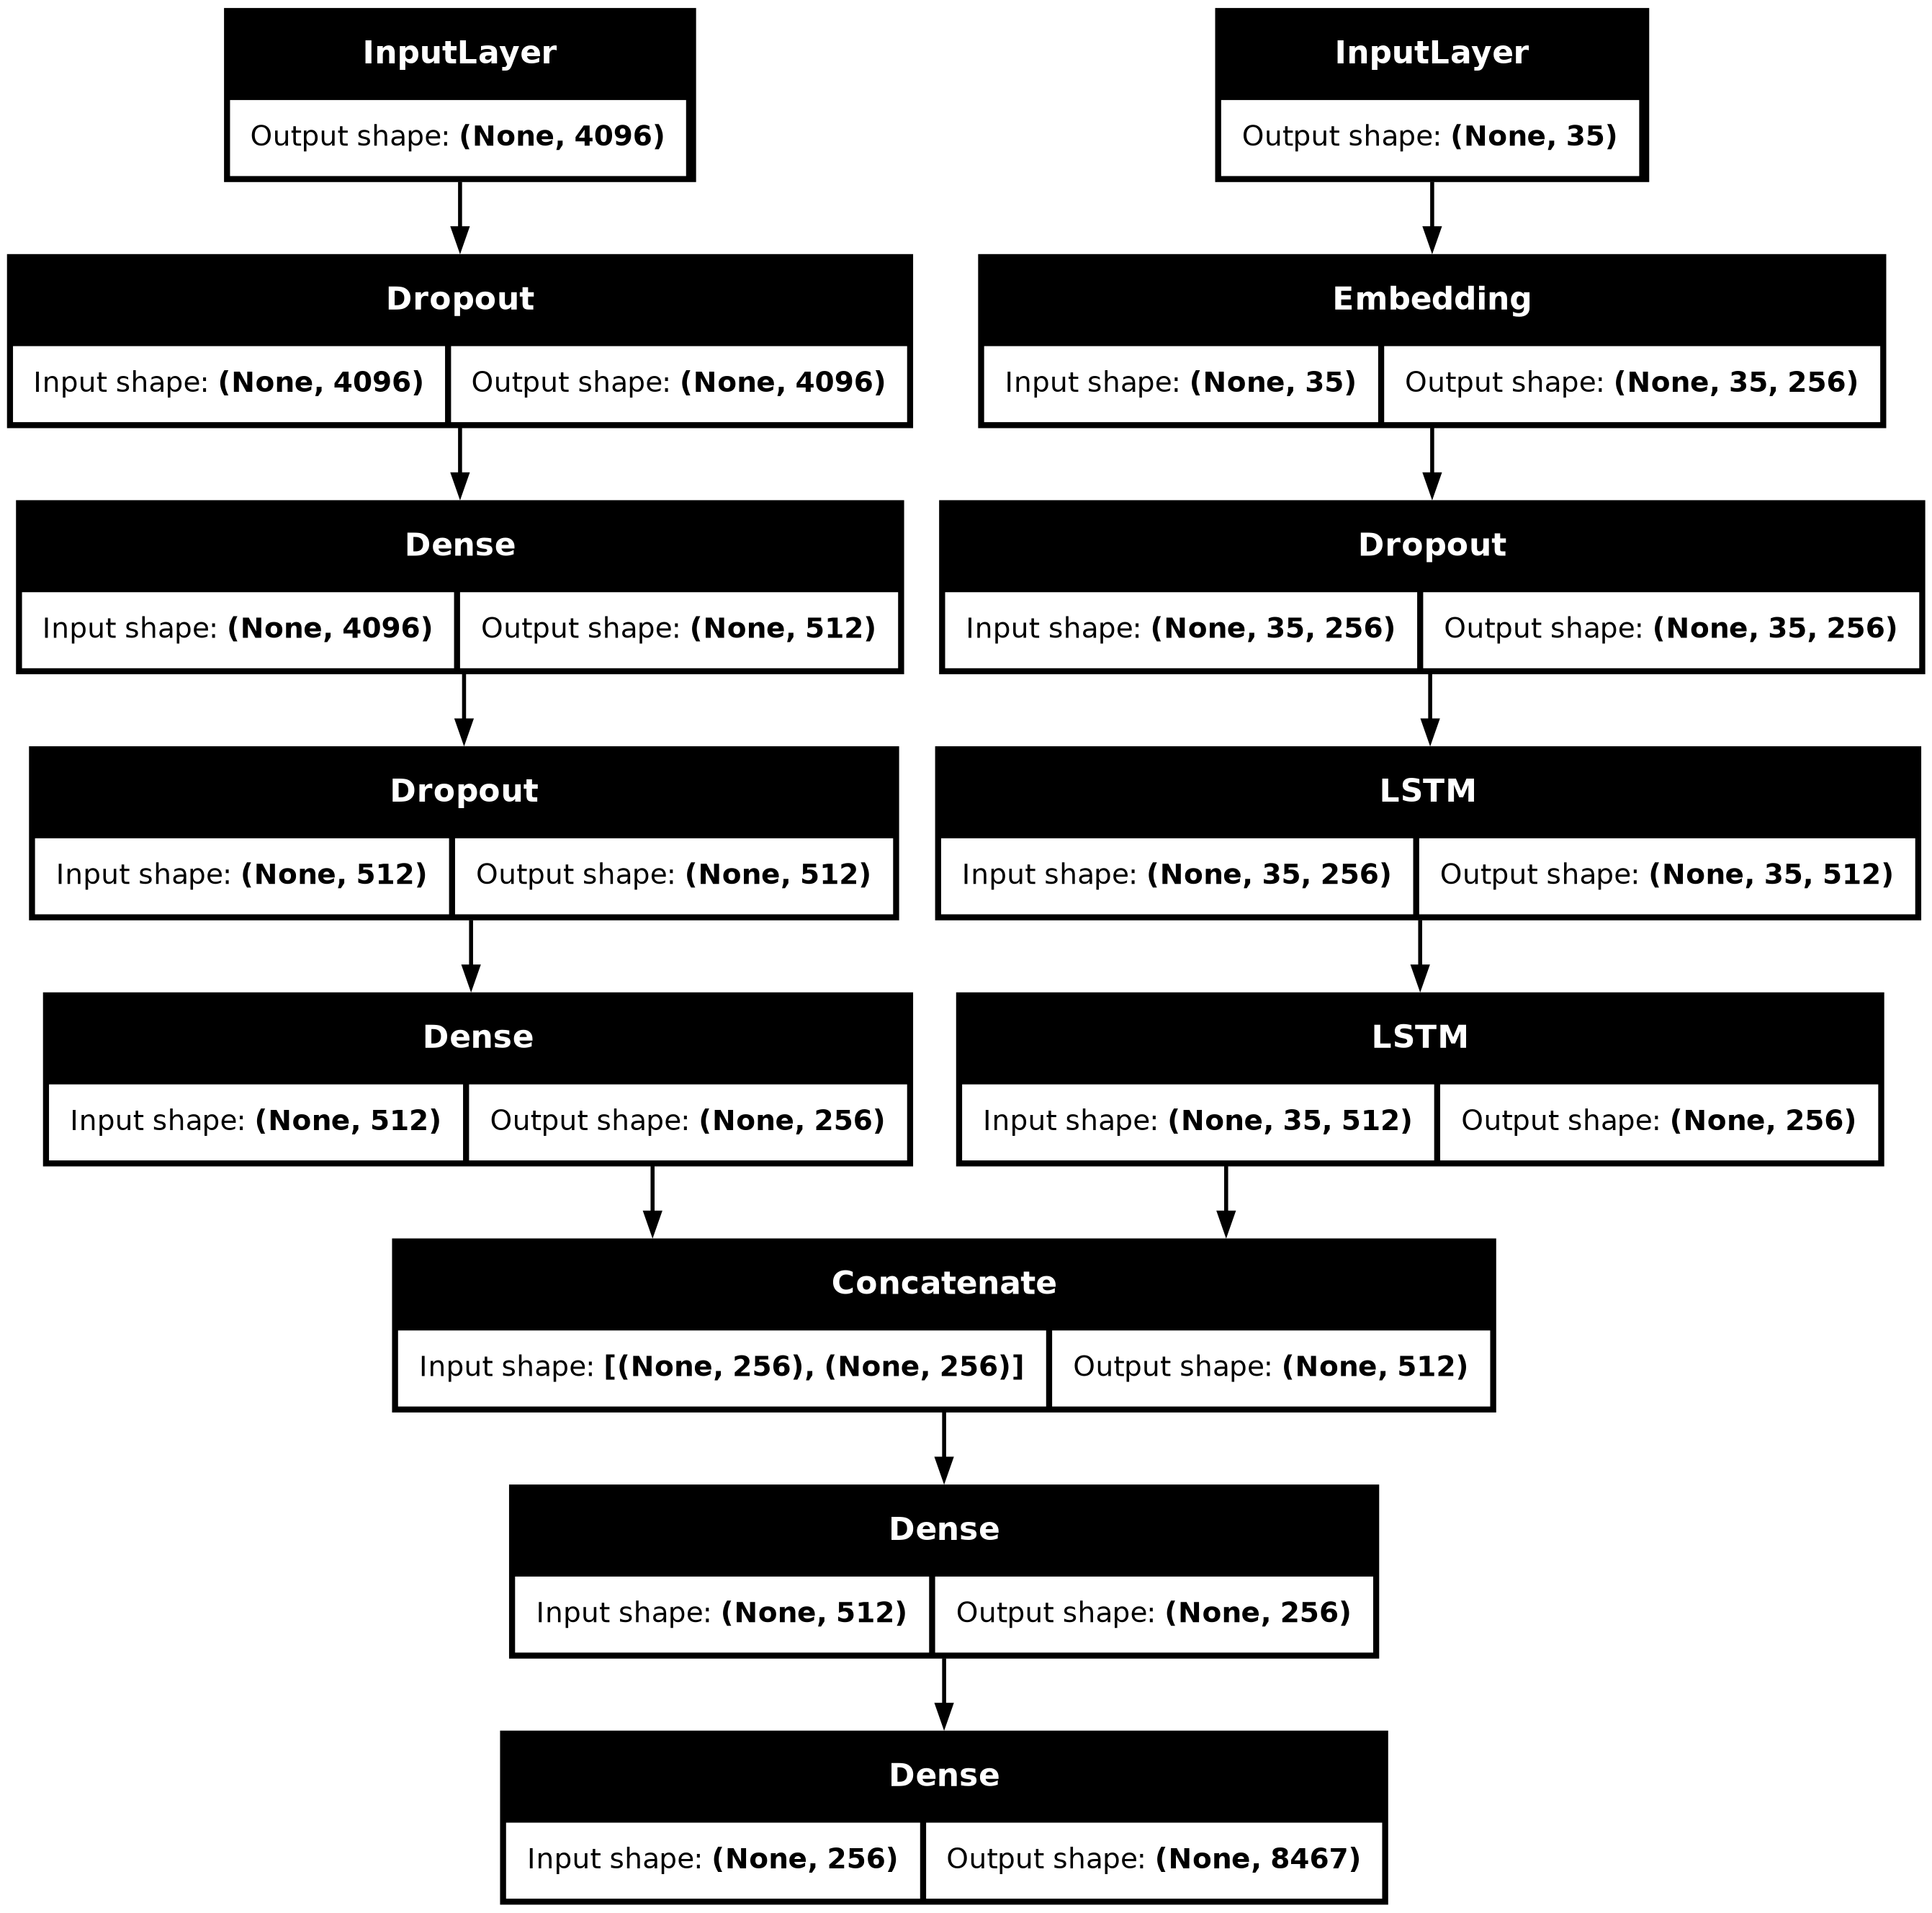

In [23]:
# Image Feature Model
inputA = Input(shape=(4096,),name="image")
feature = Dropout(0.2)(inputA)
feature = Dense(512,activation='relu')(feature)
feature = Dropout(0.2)(feature)
feature = Dense(256,activation='relu')(feature)

# Caption Text Model
inputB = Input(shape=(max_length,),name="caption")
caption = Embedding(vocab_size,256)(inputB)
caption = Dropout(0.2)(caption)
caption = LSTM(512,return_sequences=True)(caption)
caption = LSTM(256)(caption)

# Combined Model
combined_model = concatenate([feature,caption])
output = Dense(256,activation='relu')(combined_model)
output = Dense(vocab_size,activation='softmax')(output)

model = Model(inputs=[inputB,inputA],outputs=output)
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])


plot_model(model,show_shapes=True)

# Train-Text Split

In [24]:
image_ids = list(caption_mapping.keys())
split_index = int(len(image_ids)*0.90)
train_image_ids = image_ids[:split_index]
test_image_ids = image_ids[split_index:]
print(len(train_image_ids))
print(len(test_image_ids))

7281
810


## Now each caption is changed in below given form - 
<pre>
startseq a girl going into a wooden building endseq
        x                                        y
startseq                                         a
startseq a                                       girl
startseq a girl                                  going
startseq a girl going                            into
....
....
startseq a girl going into a wooden building     endseq
</pre>

In [25]:
def data_generator(images_id,caption_mapping,image_features,tokenizer,max_length,vocab_size,batch_size):
    x1, x2, y = list(), list(), list()
    n = 0
    for key in images_id:
        n=n+1
        for caption in caption_mapping[key]:
            seq = tokenizer.texts_to_sequences([caption])[0]
            for i in range(1,len(seq)):
                in_seq,out_seq = seq[:i],seq[i]
                in_seq = pad_sequences([in_seq],maxlen=max_length)[0]
                out_seq = to_categorical([out_seq],num_classes=vocab_size)[0]
                x1.append(image_features[key][0])
                x2.append(in_seq)
                y.append(out_seq)

        if n == batch_size:
            x1, x2, y = np.array(x1), np.array(x2), np.array(y)
            yield {'image':x1, 'caption':x2},y
            x1, x2, y = list(), list(), list()
            n = 0

In [26]:
epochs = 50
batch_size = 32
steps = (len(train_image_ids) + batch_size - 1) // batch_size  # Ensure all samples are covered

for i in range(epochs):
    xy = data_generator(train_image_ids, caption_mapping, image_features, tokenizer, max_length, vocab_size, batch_size)
    model.fit(xy, epochs=1, steps_per_epoch=steps, verbose=1,shuffle=True)

228/228 ━━━━━━━━━━━━━━━━━━━━ 77s 315ms/step - accuracy: 0.1079 - loss: 5.8424
228/228 ━━━━━━━━━━━━━━━━━━━━ 76s 331ms/step - accuracy: 0.2371 - loss: 4.1913
228/228 ━━━━━━━━━━━━━━━━━━━━ 78s 340ms/step - accuracy: 0.2808 - loss: 3.6862
228/228 ━━━━━━━━━━━━━━━━━━━━ 79s 346ms/step - accuracy: 0.3055 - loss: 3.3943
228/228 ━━━━━━━━━━━━━━━━━━━━ 80s 352ms/step - accuracy: 0.3215 - loss: 3.1903
228/228 ━━━━━━━━━━━━━━━━━━━━ 81s 353ms/step - accuracy: 0.3360 - loss: 3.0264
228/228 ━━━━━━━━━━━━━━━━━━━━ 81s 354ms/step - accuracy: 0.3479 - loss: 2.8929
228/228 ━━━━━━━━━━━━━━━━━━━━ 81s 354ms/step - accuracy: 0.3619 - loss: 2.7848
228/228 ━━━━━━━━━━━━━━━━━━━━ 81s 354ms/step - accuracy: 0.3732 - loss: 2.6908
228/228 ━━━━━━━━━━━━━━━━━━━━ 81s 354ms/step - accuracy: 0.3856 - loss: 2.6026
228/228 ━━━━━━━━━━━━━━━━━━━━ 81s 353ms/step - accuracy: 0.3963 - loss: 2.5233
228/228 ━━━━━━━━━━━━━━━━━━━━ 81s 353ms/step - accuracy: 0.4076 - loss: 2.4469
228/228 ━━━━━━━━━━━━━━━━━━━━ 81s 354ms/step - accuracy: 0.4176 -

In [27]:
model.save(WORKING_DIR+"/best_model.h5")

# Predict Captions for Test Images

In [28]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [29]:
def predict_caption(model,image,tokenizer,max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence],max_length)
        yhat = model.predict([sequence,image],verbose=0)
        yhat = np.argmax(yhat)
        word = idx_to_word(yhat,tokenizer)
        if word is None:
            break
        in_text += " " + word
        if word == "endseq":
            break
            
    return in_text

# Visualize the Result

---------------------------------Image------------------------------


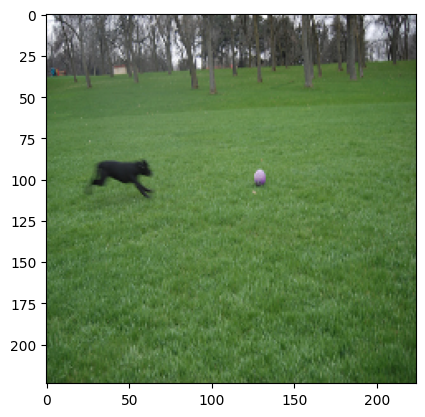

-------------------------Original Caption----------------------------
startseq black dog chases ball in the grass endseq
startseq black dog is chasing ball on green grass endseq
startseq dog and ball on green grass and in front of trees endseq
startseq dog chases ball in the grass endseq
startseq green grass field black dog running after ball endseq
-------------------------Predicted Caption----------------------------
startseq dog is about to catch thrown volleyball on an object endseq


In [30]:
img_directory = os.path.join(BASE_DIR,"images")
image_key = test_image_ids[57]

print("---------------------------------Image------------------------------")
image_name = image_key + ".jpg"
image_path = img_directory + "/" + image_name
image = cv2.imread(image_path)
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
image = cv2.resize(image,(224,224),cv2.INTER_CUBIC)
plt.imshow(image)
plt.show()      

print("-------------------------Original Caption----------------------------")
captions = caption_mapping[image_key]
for caption in captions:
    print(caption)
    
print("-------------------------Predicted Caption----------------------------")
predicted_caption = predict_caption(model,image_features[image_key],tokenizer,max_length)
print(predicted_caption)

In [31]:
from nltk.translate.bleu_score import corpus_bleu

actual, predicted = list(), list()

for key in tqdm(test_image_ids):
    captions = caption_mapping[key]
    y_pred = predict_caption(model,image_features[key],tokenizer,max_length)
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    actual.append(actual_captions)
    predicted.append(y_pred)
    
print("BLEU-1: %f" %corpus_bleu(actual,predicted,weights=(1,0,0,0)))
print("BLEU-2: %f" %corpus_bleu(actual,predicted,weights=(0.5,0.5,0,0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.489624
BLEU-2: 0.266140
